### Plots for pretraining model dimensionality reductions.
#### 1. Imports, Datasets, and Models.

In [2]:
import matplotlib.pyplot as plt
import numpy as np

from pretrain_model import AMPPretrainLearner
model = AMPPretrainLearner()
model.load_weights('./c_transfer_learning/models_pretrain/amp_pretrain_learner_weights.h5')

from b_preprocessing.pretrain_tokenizer import AMPTokenizer
tokenizer = AMPTokenizer(15)
aa_codes = tokenizer.aa_dict

train_seq  : np.ndarray = np.load('./b_preprocessing/pretrain/train_seq.npy'  )
train_label: np.ndarray = np.load('./b_preprocessing/pretrain/train_label.npy')[:, np.newaxis]
valid_seq  : np.ndarray = np.load('./b_preprocessing/pretrain/valid_seq.npy'  )
valid_label: np.ndarray = np.load('./b_preprocessing/pretrain/valid_label.npy')[:, np.newaxis]

2023-06-02 11:17:54.916291: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2023-06-02 11:17:54.916394: W tensorflow/stream_executor/cuda/cuda_driver.cc:263] failed call to cuInit: UNKNOWN ERROR (303)
2023-06-02 11:17:54.916420: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (zimei): /proc/driver/nvidia/version does not exist
2023-06-02 11:17:54.922369: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


#### 2. AA word embeddings.

In [3]:
aa_embed = []
for aa in aa_codes.keys():
  token = tokenizer.tokenize_seq(f'{aa}')
  aa_embed.append(model.l_we.embedding(token, training = False)[0].numpy())

**UMAP**

/home/songzl/software/miniconda3/envs/dl_amp/lib/python3.8/site-packages/numba/np/ufunc/parallel.py:363: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 6103. The TBB threading layer is disabled.
  warnings.warn(problem)
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


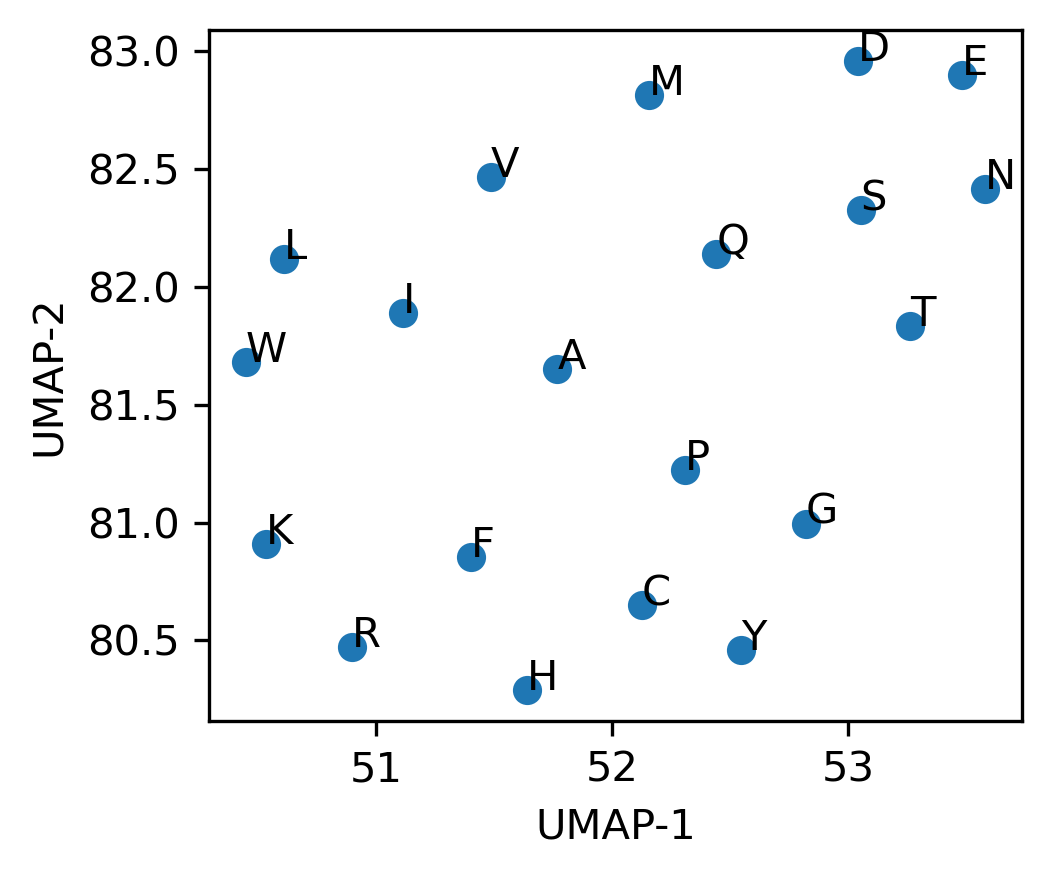

In [4]:
from umap import UMAP

aa_embed_umap = UMAP(n_neighbors=10, random_state=0, n_epochs=10_000).fit_transform(aa_embed)

fig, ax = plt.subplots(figsize=(3.5, 3.5), nrows=1, ncols=1, dpi=300)

ax.scatter(x=aa_embed_umap[:, 0], y=aa_embed_umap[:, 1])

# labels.
for i in range(len(list(aa_codes.keys()))):
    ax.annotate(list(aa_codes.keys())[i], xy=(aa_embed_umap[i, 0], aa_embed_umap[i, 1]))

ax.set_aspect('equal', adjustable='box')
ax.set_xlabel('UMAP-1')
ax.set_ylabel('UMAP-2')

np.savetxt('./z_figures/pretrain_aa_embeding_x.dat', aa_embed_umap[:, 0])
np.savetxt('./z_figures/pretrain_aa_embeding_y.dat', aa_embed_umap[:, 1])

plt.savefig('./z_figures/pretrain_aa_embeding.png')
plt.show()

#### 3. Pretrained Latent Representations

In [4]:
train_latent = model(train_seq, training=False)
train_latent = model.cross_attn_latent.numpy().flatten().reshape((-1, model.prm_d_model * model.prm_max_seqlen))
valid_latent = model(valid_seq, training=False)
valid_latent = model.cross_attn_latent.numpy().flatten().reshape((-1, model.prm_d_model * model.prm_max_seqlen))
all_latent = np.concatenate((train_latent, valid_latent), axis=0)

all_label = np.concatenate((train_label.flatten(), valid_label.flatten()), axis=0)

print(f"Latent vector shape of the Training   set: {train_latent.shape}.\nLatent vector shape of the Validation set: {valid_latent.shape}.\nMerged Latent shape: {all_latent.shape}")

umap = UMAP(n_neighbors=500, random_state=0)

all_latent_umap = umap.fit_transform(all_latent)
neg_latent_dimred = all_latent_umap[np.where(all_label==0)]
pos_latent_dimred = all_latent_umap[np.where(all_label==1)]

neg_latent_dimred.shape, pos_latent_dimred.shape

2023-06-01 21:56:16.121534: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 73827360 exceeds 10% of free system memory.
2023-06-01 21:56:16.131742: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 73827360 exceeds 10% of free system memory.
2023-06-01 21:56:16.151882: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 73827360 exceeds 10% of free system memory.
2023-06-01 21:56:16.167561: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 590618880 exceeds 10% of free system memory.
2023-06-01 21:56:16.230590: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 590618880 exceeds 10% of free system memory.


Latent vector shape of the Training   set: (51269, 360).
Latent vector shape of the Validation set: (12815, 360).
Merged Latent shape: (64084, 360)


((60910, 2), (3174, 2))

**UMAP**

[[ 6.192535  -2.3268423]]


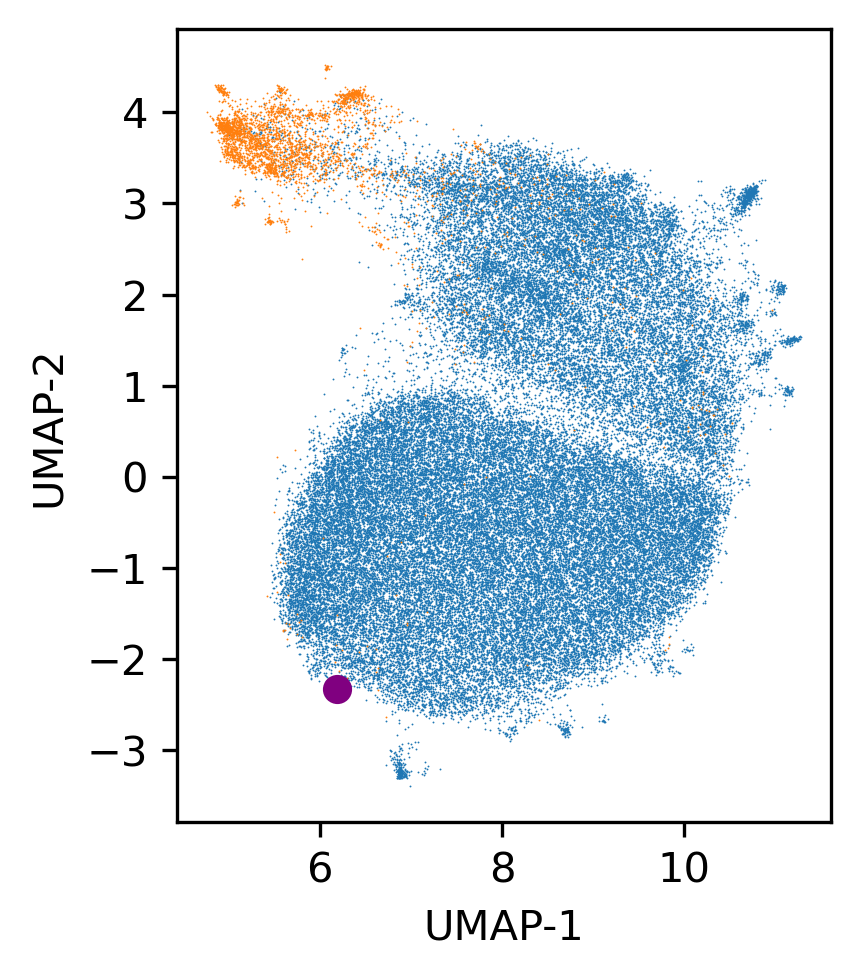

In [13]:
fig, ax = plt.subplots(figsize=(3.5, 3.5), nrows=1, ncols=1, dpi=300, sharex=True, sharey=True)
ax.scatter(x=neg_latent_dimred[:, 0], y=neg_latent_dimred[:, 1], s=.2, linewidths=0, label='noamp')
ax.scatter(x=pos_latent_dimred[:, 0], y=pos_latent_dimred[:, 1], s=.2, linewidths=0, label='    amp')

ax.set_aspect('equal', adjustable='box')
ax.set_xlabel('UMAP-1')
ax.set_ylabel('UMAP-2')

np.savetxt('./z_figures/pretrain_latent_umap_nomod_noamp_x.dat', neg_latent_dimred[:, 0])
np.savetxt('./z_figures/pretrain_latent_umap_nomod_noamp_y.dat', neg_latent_dimred[:, 1])
np.savetxt('./z_figures/pretrain_latent_umap_nomod___amp_x.dat', pos_latent_dimred[:, 0])
np.savetxt('./z_figures/pretrain_latent_umap_nomod___amp_y.dat', pos_latent_dimred[:, 1])

aa14_token  = tokenizer.tokenize_seq('MKKWMKLLRHITSP')
aa14_latent = model(aa14_token, training=False)
aa14_latent = model.cross_attn_latent.numpy().flatten().reshape((-1, model.prm_d_model * model.prm_max_seqlen))
aa14_latent_umap = umap.transform(aa14_latent)
ax.scatter(x=[aa14_latent_umap[0][0]], y=[aa14_latent_umap[0][1]], c = 'purple')
print(aa14_latent_umap)

plt.savefig('./z_figures/pretrain_latent_umap.png')
plt.show()